In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime, timedelta
from pytrends.request import TrendReq

In [7]:
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["tesla"],timeframe='2021-03-01 2021-11-01')
trends = pytrend.interest_over_time()
trendsdf = pd.DataFrame(data = {'date': trends.index.tolist(),
                                'search': trends["tesla"].tolist()})
trendsdf['date'] = pd.to_datetime(trendsdf['date'])
trendsdf

,date,search
0,2021-03-01,59
1,2021-03-02,59
2,2021-03-03,54
3,2021-03-04,64
4,2021-03-05,79
...,...,...
241,2021-10-28,66
242,2021-10-29,69
243,2021-10-30,52
244,2021-10-31,53


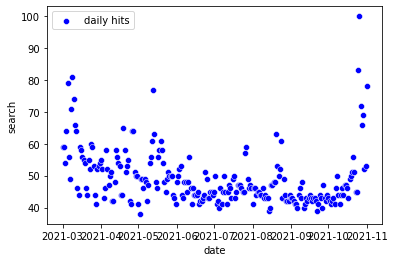

In [8]:
sns.scatterplot( x = 'date',
             y = 'search',
             data = trendsdf,
             label = 'daily hits', color="blue")
plt.show()